## 1. Introduction

### 1.1 Goal of the project

The goal of the project is to implement **Least Squares based 2D Bearing Only SLAM** having:
- 2D Bearing only labeled observations
- Odometry

as inputs and yielding:
- Trajectory
- Map

### 1.2 Used tools

The implementation is done using existing code from [Probabilistic Robotics 17/18 course repo](https://gitlab.com/grisetti/probabilistic_robotics_2017_18), particularly two applications:
1. [EKF Localization (bearing only)](https://gitlab.com/grisetti/probabilistic_robotics_2017_18/tree/master/applications/octave/08_ekf_localization)
2. [Total Least Squares SLAM](https://gitlab.com/grisetti/probabilistic_robotics_2017_18/tree/master/applications/octave/26_total_least_squares)

W.r.t. tools used, it is done in Jupyter Notebook with [Octave kernel](https://github.com/Calysto/octave_kernel), beacause, unlike native Octave GUI, it allows to create neat reports with runnable code inside and doesn't crash each time you want to plot a graph.

In [13]:
# bookeeping of the indices
# dimensions

%(minimal) size of pose and landmarks
global pose_dim=6;
global landmark_dim=3;


# retrieves the index in the perturbation vector, that corresponds to
# a certain pose
# input:
#   pose_index:     the index of the pose for which we want to compute the
#                   index
#   num_poses:      number of pose variables in the state
#   num_landmarks:  number of pose variables in the state
# output:
#   v_idx: the index of the sub-vector corrsponding to 
#          pose_index, in the array of perturbations  (-1 if error)


function v_idx=poseMatrixIndex(pose_index, num_poses, num_landmarks)
  global pose_dim;
  global landmark_dim;

  if (pose_index>num_poses)
    v_idx=-1;
    return;
  endif;
  v_idx=1+(pose_index-1)*pose_dim;
endfunction;

# retrieves the index in the perturbation vector, that corresponds to
# a certain landmark
# input:
#   landmark_index:     the index of the landmark for which we want to compute the
#                   index
#   num_poses:      number of pose variables in the state
#   num_landmarks:  number of pose variables in the state
# output:
#   v_idx: the index of the perturnation corrsponding to the
#           landmark_index, in the array of perturbations

function v_idx=landmarkMatrixIndex(landmark_index, num_poses, num_landmarks)
  global pose_dim;
  global landmark_dim;
  if (landmark_index>num_landmarks)
    v_idx=-1;
    return;
  endif;
  v_idx=1 + (num_poses)*pose_dim + (landmark_index-1) * landmark_dim;
endfunction;


In [14]:
# Assembly of the landmark-based problem
source "../tools/utilities/geometry_helpers_3d.m"
%source "./total_least_squares_indices.m"
%(minimal) size of pose and landmarks


# error and jacobian of a measured landmark
# input:
#   Xr: the robot pose in world frame (4x4 homogeneous matrix)
#   Xl: the landmark pose (3x1 vector, 3d pose in world frame)
#   z:  measured position of landmark
# output:
#   e: 3x1 is the difference between prediction and measurement
#   Jr: 3x6 derivative w.r.t a the error and a perturbation on the
#       pose
#   Jl: 3x3 derivative w.r.t a the error and a perturbation on the
#       landmark

function [e,Jr,Jl]=landmarkErrorAndJacobian(Xr,Xl,z)
  # inverse transform
  iR=Xr(1:3,1:3)';
  it=-iR*Xr(1:3,4);
  
  #prediction
  z_hat=iR*Xl+it; 
  e=z_hat-z;
  Jr=zeros(3,6);
  Jr(1:3,1:3)=-iR;
  Jr(1:3,4:6)=iR*skew(Xl);
  Jl=iR;
endfunction;


#linearizes the robot-landmark measurements
#   XR: the initial robot poses (4x4xnum_poses: array of homogeneous matrices)
#   XL: the initial landmark estimates (3xnum_landmarks matrix of landmarks)
#   Z:  the measurements (3xnum_measurements)
#   associations: 2xnum_measurements. 
#                 associations(:,k)=[p_idx,l_idx]' means the kth measurement
#                 refers to an observation made from pose p_idx, that
#                 observed landmark l_idx
#   num_poses: number of poses in XR (added for consistency)
#   num_landmarks: number of landmarks in XL (added for consistency)
#   kernel_threshod: robust kernel threshold
# output:
#   XR: the robot poses after optimization
#   XL: the landmarks after optimization
#   chi_stats: array 1:num_iterations, containing evolution of chi2
#   num_inliers: array 1:num_iterations, containing evolution of inliers

function [H,b, chi_tot, num_inliers]=linearizeLandmarks(XR, XL, Zl, associations,num_poses, num_landmarks, kernel_threshold)
  global pose_dim;
  global landmark_dim;
  system_size=pose_dim*num_poses+landmark_dim*num_landmarks; 
  H=zeros(system_size, system_size);
  b=zeros(system_size,1);
  chi_tot=0;
  num_inliers=0;
  for (measurement_num=1:size(Zl,2))
    pose_index=associations(1,measurement_num);
    landmark_index=associations(2,measurement_num);
    z=Zl(:,measurement_num);
    Xr=XR(:,:,pose_index);
    Xl=XL(:,landmark_index);
    [e,Jr,Jl] = landmarkErrorAndJacobian(Xr, Xl, z);
    chi=e'*e;
    if (chi>kernel_threshold)
      e*=sqrt(kernel_threshold/chi);
      chi=kernel_threshold;
    else
      num_inliers++;
    endif;
    chi_tot+=chi;

    pose_matrix_index=poseMatrixIndex(pose_index, num_poses, num_landmarks);
    landmark_matrix_index=landmarkMatrixIndex(landmark_index, num_poses, num_landmarks);

    H(pose_matrix_index:pose_matrix_index+pose_dim-1,
      pose_matrix_index:pose_matrix_index+pose_dim-1)+=Jr'*Jr;

    H(pose_matrix_index:pose_matrix_index+pose_dim-1,
      landmark_matrix_index:landmark_matrix_index+landmark_dim-1)+=Jr'*Jl;

    H(landmark_matrix_index:landmark_matrix_index+landmark_dim-1,
      landmark_matrix_index:landmark_matrix_index+landmark_dim-1)+=Jl'*Jl;

    H(landmark_matrix_index:landmark_matrix_index+landmark_dim-1,
      pose_matrix_index:pose_matrix_index+pose_dim-1)+=Jl'*Jr;

    b(pose_matrix_index:pose_matrix_index+pose_dim-1)+=Jr'*e;
    b(landmark_matrix_index:landmark_matrix_index+landmark_dim-1)+=Jl'*e;
  endfor
endfunction


In [15]:
source "../tools/utilities/geometry_helpers_3d.m"
%source "./total_least_squares_indices.m"

# error and jacobian of a measured pose, all poses are in world frame
# input:
#   Xi: the observing robot pose (4x4 homogeneous matrix)
#   Xj: the observed robot pose (4x4 homogeneous matrix)
#   Z:   the relative transform measured between Xr1 and Xr2
#   e: 12x1 is the difference between prediction, and measurement, vectorized
#   Ji : 12x6 derivative w.r.t a the error and a perturbation of the
#       first pose
#   Jj : 12x6 derivative w.r.t a the error and a perturbation of the
#       second pose

function [e,Ji,Jj]=poseErrorAndJacobian(Xi,Xj,Z)
  global Rx0;
  global Ry0;
  global Rz0;
  Ri=Xi(1:3,1:3);
  Rj=Xj(1:3,1:3);
  ti=Xi(1:3,4);
  tj=Xj(1:3,4);
  tij=tj-ti;
  Ri_transpose=Ri';
  Ji=zeros(12,6);
  Jj=zeros(12,6);
  
  dR_dax=Ri_transpose*Rx0*Rj;
  dR_day=Ri_transpose*Ry0*Rj;
  dR_daz=Ri_transpose*Rz0*Rj;
  
  Jj(1:9,4)=reshape(dR_dax, 9, 1);
  Jj(1:9,5)=reshape(dR_day, 9, 1);
  Jj(1:9,6)=reshape(dR_daz, 9, 1);
  Jj(10:12,1:3)=Ri_transpose;
  
  Jj(10:12,4:6)=-Ri_transpose*skew(tj);
  Ji=-Jj;

  Z_hat=eye(4);
  Z_hat(1:3,1:3)=Ri_transpose*Rj;
  Z_hat(1:3,4)=Ri_transpose*tij;
  e=flattenIsometryByColumns(Z_hat-Z);
 endfunction;

#linearizes the robot-robot measurements
# inputs:
#   XR: the initial robot poses (4x4xnum_poses: array of homogeneous matrices)
#   XL: the initial landmark estimates (3xnum_landmarks matrix of landmarks)
#   ZR: the robot_robot measuremenrs (4x4xnum_measurements: array of homogeneous matrices)
#   associations: 2xnum_measurements. 
#                 associations(:,k)=[i_idx, j_idx]' means the kth measurement
#                 refers to an observation made from pose i_idx, that
#                 observed the pose j_idx
#   num_poses: number of poses in XR (added for consistency)
#   num_landmarks: number of landmarks in XL (added for consistency)
#   kernel_threshod: robust kernel threshold
# outputs:
#   H: the H matrix, filled
#   b: the b vector, filled
#   chi_tot: the total chi2 of the current round
#   num_inliers: number of measurements whose error is below kernel_threshold

function [H,b, chi_tot, num_inliers]=linearizePoses(XR, XL, Zr, associations,num_poses, num_landmarks, kernel_threshold)
  global pose_dim;
  global landmark_dim;
  system_size=pose_dim*num_poses+landmark_dim*num_landmarks; 
  H=zeros(system_size, system_size);
  b=zeros(system_size,1);
  chi_tot=0;
  num_inliers=0;
  for (measurement_num=1:size(Zr,3))
    Omega=eye(12);
    Omega(1:9,1:9)*=1e3; # we need to pimp the rotation  part a little
    pose_i_index=associations(1,measurement_num);
    pose_j_index=associations(2,measurement_num);
    Z=Zr(:,:,measurement_num);
    Xi=XR(:,:,pose_i_index);
    Xj=XR(:,:,pose_j_index);
    [e,Ji,Jj] = poseErrorAndJacobian(Xi, Xj, Z);
    chi=e'*Omega*e;
    if (chi>kernel_threshold)
      Omega*=sqrt(kernel_threshold/chi);
      chi=kernel_threshold;
    else
      num_inliers ++;
    endif;
    chi_tot+=chi;

    pose_i_matrix_index=poseMatrixIndex(pose_i_index, num_poses, num_landmarks);
    pose_j_matrix_index=poseMatrixIndex(pose_j_index, num_poses, num_landmarks);
    
    H(pose_i_matrix_index:pose_i_matrix_index+pose_dim-1,
      pose_i_matrix_index:pose_i_matrix_index+pose_dim-1)+=Ji'*Omega*Ji;

    H(pose_i_matrix_index:pose_i_matrix_index+pose_dim-1,
      pose_j_matrix_index:pose_j_matrix_index+pose_dim-1)+=Ji'*Omega*Jj;

    H(pose_j_matrix_index:pose_j_matrix_index+pose_dim-1,
      pose_i_matrix_index:pose_i_matrix_index+pose_dim-1)+=Jj'*Omega*Ji;

    H(pose_j_matrix_index:pose_j_matrix_index+pose_dim-1,
      pose_j_matrix_index:pose_j_matrix_index+pose_dim-1)+=Jj'*Omega*Jj;

    b(pose_i_matrix_index:pose_i_matrix_index+pose_dim-1)+=Ji'*Omega*e;
    b(pose_j_matrix_index:pose_j_matrix_index+pose_dim-1)+=Jj'*Omega*e;
  endfor
endfunction


In [16]:
# Assembly of the projection problem
source "../tools/utilities/geometry_helpers_3d.m"
%source "./total_least_squares_indices.m"


# camera matrix
global K=[150,0,320;
          0, 150,240;
          0, 0, 1];

# image_size
global image_rows=480;
global image_cols=540;

# dimension of projection
global projection_dim=2;


# projects a point
function p_img=projectPoint(Xr,Xl)
  global image_cols;
  global image_rows;
  global K;
  iXr=inv(Xr);
  p_img=[-1;-1];
  pw=iXr(1:3,1:3)*Xl+iXr(1:3,4);
  if (pw(3)<0)
     return;
  endif;
  p_cam=K*pw;
  iz=1./p_cam(3);
  p_cam*=iz;
  if (p_cam(1)<0 || 
      p_cam(1)>image_cols ||
      p_cam(2)<0 || 
      p_cam(2)>image_rows)
    return;
  endif;
  p_img=p_cam(1:2);
endfunction

# error and jacobian of a measured landmark
# input:
#   Xr: the robot pose in world frame (4x4 homogeneous matrix)
#   Xl: the landmark pose (3x1 vector, 3d pose in world frame)
#   z:  projection of the landmark on the image plane
# output:
#   e: 2x1 is the difference between prediction and measurement
#   Jr: 2x6 derivative w.r.t a the error and a perturbation on the
#       pose
#   Jl: 2x3 derivative w.r.t a the error and a perturbation on the
#       landmark
#   is_valid: true if projection ok

function [is_valid, e,Jr,Jl]=projectionErrorAndJacobian(Xr,Xl,z)
  global K;
  global image_rows;
  global image_cols;
  is_valid=false;
  e=[0;0];
  Jr=zeros(2,6);
  Jl=zeros(2,3);
  
  # inverse transform
  iR=Xr(1:3,1:3)';
  it=-iR*Xr(1:3,4);

  pw=iR*Xl+it; #point prediction, in world scale
  if (pw(2)<0)
     return;
  endif

  Jwr=zeros(3,6);
  Jwr(1:3,1:3)=-iR;
  Jwr(1:3,4:6)=iR*skew(Xl);
  Jwl=iR;
  
  p_cam=K*pw;
  iz=1./p_cam(3);
  z_hat=p_cam(1:2)*iz;
  if (z_hat(1)<0 || 
      z_hat(1)>image_cols ||
      z_hat(2)<0 || 
      z_hat(2)>image_rows)
    return;
  endif;

  iz2=iz*iz;
  Jp=[iz, 0, -p_cam(1)*iz2;
      0, iz, -p_cam(2)*iz2];
  
  e=z_hat-z;
  Jr=Jp*K*Jwr;
  Jl=Jp*K*Jwl;
  is_valid=true;
endfunction;


#linearizes the robot-landmark measurements
#   XR: the initial robot poses (4x4xnum_poses: array of homogeneous matrices)
#   XL: the initial landmark estimates (3xnum_landmarks matrix of landmarks)
#   Z:  the measurements (2xnum_measurements)
#   associations: 2xnum_measurements. 
#                 associations(:,k)=[p_idx,l_idx]' means the kth measurement
#                 refers to an observation made from pose p_idx, that
#                 observed landmark l_idx
#   num_poses: number of poses in XR (added for consistency)
#   num_landmarks: number of landmarks in XL (added for consistency)
#   kernel_threshod: robust kernel threshold
# output:
#   XR: the robot poses after optimization
#   XL: the landmarks after optimization
#   chi_stats: array 1:num_iterations, containing evolution of chi2
#   num_inliers: array 1:num_iterations, containing evolution of inliers

function [H,b, chi_tot, num_inliers]=linearizeProjections(XR, XL, Zl, associations,num_poses, num_landmarks, kernel_threshold)
  global pose_dim;
  global landmark_dim;
  system_size=pose_dim*num_poses+landmark_dim*num_landmarks; 
  H=zeros(system_size, system_size);
  b=zeros(system_size,1);
  chi_tot=0;
  num_inliers=0;
  for (measurement_num=1:size(Zl,2))
    pose_index=associations(1,measurement_num);
    landmark_index=associations(2,measurement_num);
    z=Zl(:,measurement_num);
    Xr=XR(:,:,pose_index);
    Xl=XL(:,landmark_index);
    [is_valid, e,Jr,Jl] = projectionErrorAndJacobian(Xr, Xl, z);
    if (! is_valid)
       continue;
    endif;
    chi=e'*e;
    if (chi>kernel_threshold)
      e*=sqrt(kernel_threshold/chi);
      chi=kernel_threshold;
    else
      num_inliers++;
    endif;
    chi_tot+=chi;

    pose_matrix_index=poseMatrixIndex(pose_index, num_poses, num_landmarks);
    landmark_matrix_index=landmarkMatrixIndex(landmark_index, num_poses, num_landmarks);

    H(pose_matrix_index:pose_matrix_index+pose_dim-1,
      pose_matrix_index:pose_matrix_index+pose_dim-1)+=Jr'*Jr;

    H(pose_matrix_index:pose_matrix_index+pose_dim-1,
      landmark_matrix_index:landmark_matrix_index+landmark_dim-1)+=Jr'*Jl;

    H(landmark_matrix_index:landmark_matrix_index+landmark_dim-1,
      landmark_matrix_index:landmark_matrix_index+landmark_dim-1)+=Jl'*Jl;

    H(landmark_matrix_index:landmark_matrix_index+landmark_dim-1,
      pose_matrix_index:pose_matrix_index+pose_dim-1)+=Jl'*Jr;

    b(pose_matrix_index:pose_matrix_index+pose_dim-1)+=Jr'*e;
    b(landmark_matrix_index:landmark_matrix_index+landmark_dim-1)+=Jl'*e;
  endfor
endfunction


In [17]:
source "../tools/utilities/geometry_helpers_3d.m"
%source "./total_least_squares_indices.m"
%source "./total_least_squares_landmarks.m"
%source "./total_least_squares_poses.m"
%source "./total_least_squares_projections.m"

# implementation of the boxplus
# applies a perturbation to a set of landmarks and robot poses
# input:
#   XR: the robot poses (4x4xnum_poses: array of homogeneous matrices)
#   XL: the landmark pose (3xnum_landmarks matrix of landmarks)
#   num_poses: number of poses in XR (added for consistency)
#   num_landmarks: number of landmarks in XL (added for consistency)
#   dx: the perturbation vector of appropriate dimensions
#       the poses come first, then the landmarks
# output:
#   XR: the robot poses obtained by applying the perturbation
#   XL: the landmarks obtained by applying the perturbation

function [XR, XL]=boxPlus(XR, XL, num_poses, num_landmarks, dx)
  global pose_dim;
  global landmark_dim;
  for(pose_index=1:num_poses)
    pose_matrix_index=poseMatrixIndex(pose_index, num_poses, num_landmarks);
    dxr=dx(pose_matrix_index:pose_matrix_index+pose_dim-1);
    XR(:,:,pose_index)=v2t(dxr)*XR(:,:,pose_index);
  endfor;
  for(landmark_index=1:num_landmarks)
    landmark_matrix_index=landmarkMatrixIndex(landmark_index, num_poses, num_landmarks);
    dxl=dx(landmark_matrix_index:landmark_matrix_index+landmark_dim-1,:);
    XL(:,landmark_index)+=dxl;
  endfor;
endfunction;


# implementation of the optimization loop with robust kernel
# applies a perturbation to a set of landmarks and robot poses
# input:
#   XR: the initial robot poses (4x4xnum_poses: array of homogeneous matrices)
#   XL: the initial landmark estimates (3xnum_landmarks matrix of landmarks)
#   Z:  the measurements (3xnum_measurements)
#   associations: 2xnum_measurements. 
#                 associations(:,k)=[p_idx,l_idx]' means the kth measurement
#                 refers to an observation made from pose p_idx, that
#                 observed landmark l_idx
#   num_poses: number of poses in XR (added for consistency)
#   num_landmarks: number of landmarks in XL (added for consistency)
#   num_iterations: the number of iterations of least squares
#   damping:      damping factor (in case system not spd)
#   kernel_threshod: robust kernel threshold

# output:
#   XR: the robot poses after optimization
#   XL: the landmarks after optimization
#   chi_stats_{l,p,r}: array 1:num_iterations, containing evolution of chi2 for landmarks, projections and poses
#   num_inliers{l,p,r}: array 1:num_iterations, containing evolution of inliers landmarks, projections and poses

function [XR, XL, chi_stats_l, num_inliers_l, chi_stats_p,
         num_inliers_p,chi_stats_r, num_inliers_r, H, b]
         = doTotalLS(XR, XL,
         Zl, landmark_associations,
         Zp, projection_associations,
         Zr, pose_associations,
         num_poses,
         num_landmarks,
         num_iterations,
         damping,
         kernel_threshold)
  
  global pose_dim;
  global landmark_dim;

  chi_stats_l=zeros(1,num_iterations);
  num_inliers_l=zeros(1,num_iterations);
  chi_stats_p=zeros(1,num_iterations);
  num_inliers_p=zeros(1,num_iterations);
  chi_stats_r=zeros(1,num_iterations);
  num_inliers_r=zeros(1,num_iterations);

  # size of the linear system
  system_size=pose_dim*num_poses+landmark_dim*num_landmarks; 
  for (iteration=1:num_iterations)
    H=zeros(system_size, system_size);
    b=zeros(system_size,1);
   
    if (num_landmarks) 
      [H_landmarks, b_landmarks, chi_, num_inliers_] = linearizeLandmarks(XR, XL, Zl, landmark_associations,num_poses, num_landmarks, kernel_threshold);
      chi_stats_l(iteration)=chi_;
      num_inliers_l(iteration)=num_inliers_;
      
      [H_projections, b_projections, chi_, num_inliers_] = linearizeProjections(XR, XL, Zp, projection_associations,num_poses, num_landmarks, kernel_threshold);
      chi_stats_p(iteration)+=chi_;
      num_inliers_p(iteration)=num_inliers_;
    endif;

    [H_poses, b_poses, chi_, num_inliers_] = linearizePoses(XR, XL, Zr, pose_associations,num_poses, num_landmarks, kernel_threshold);
    chi_stats_r(iteration)+=chi_;
    num_inliers_r(iteration)=num_inliers_;
    
    
    H=H_poses;
    b=b_poses;
    if (num_landmarks) 
       H+=H_landmarks+H_projections;
       b+=b_landmarks+b_projections;
    endif;

    H+=eye(system_size)*damping;
    dx=zeros(system_size,1);

    % we solve the linear system, blocking the first pose
    % this corresponds to "remove" from H and b the locks
    % of the 1st pose, while solving the system

    dx(pose_dim+1:end)=-(H(pose_dim+1:end,pose_dim+1:end)\b(pose_dim+1:end,1));
    [XR, XL]=boxPlus(XR,XL,num_poses, num_landmarks, dx);


  endfor
endfunction


parse error:

  syntax error

>>> function [XR, XL, chi_stats_l, num_inliers_l, chi_stats_p,
                                                             ^

parse error:

  syntax error

>>>          num_inliers_p,chi_stats_r, num_inliers_r, H, b]
                                                           ^

parse error:

  syntax error

>>>          = doTotalLS(XR, XL,
             ^

Zl =

 Columns 1 through 6:

   4.3241e+00   1.5216e+00  -7.0216e-02  -2.5860e+00  -3.0856e+00  -3.0628e+00
   4.4820e+00  -1.7479e+00  -3.0333e-01  -6.2448e-01   4.5340e+00   3.4780e+00
   2.7867e+00   7.7256e-01  -1.7156e+00  -1.4479e+00   4.0812e+00   4.3459e+00

 Columns 7 through 12:

  -3.6344e+00   3.8630e+00  -3.8842e+00   8.9256e-01   4.6772e+00  -2.5392e+00
  -1.8567e+00  -2.7141e+00  -4.9699e-01  -6.5321e-01  -1.2448e+00  -2.2831e+00
   1.2096e+00  -1.8120e+00  -4.0993e-01  -3.2914e+00   4.8275e+00   4.6638e+00

 Columns 13 through 18:

  -3.7168e+00  -3.4762e+00   3.5003e+00  -4.8752e+00  -8.

   7.5068e+00  -1.0138e+00  -1.2514e+00   3.5381e+00   2.6040e+00   4.6864e+00

 Columns 181 through 186:

   4.7159e+00  -2.6470e+00   4.6689e+00  -4.5206e+00   5.2106e-01  -4.4139e+00
  -1.9044e-01   5.0828e+00  -4.9316e-01   4.0275e+00  -1.5979e+00   1.1758e+00
   1.0736e+00   2.3240e+00  -7.4626e-01  -9.5100e-01   3.2706e-01   9.5263e-01

 Columns 187 through 192:

   4.4005e+00   3.1047e+00   1.6624e+00  -3.3076e+00  -4.9457e+00  -1.5279e+00
   1.1531e-01  -2.2077e-01  -2.4763e+00   4.2392e+00   4.4843e+00   2.0491e-01
  -2.8973e+00  -1.2838e+00   3.1445e-01   1.8837e-01   5.9441e+00   2.3436e+00

 Columns 193 through 198:

   3.2650e+00   2.3353e-01   2.1342e-01  -1.0379e+00  -4.3433e+00   1.3378e+00
  -2.8830e-01   6.5698e+00  -2.7658e+00   5.7080e+00   3.0679e+00  -1.3364e+00
   4.1846e+00   1.6248e-01  -6.4828e-01   1.2149e+00   1.3327e+00   1.9001e+00

 Columns 199 through 204:

   1.3896e+00  -5.0165e+00   6.8226e+00  -5.2560e-02  -3.9065e-01  -1.0994e+00
   6.8756e+00   2.2

  -5.3531e+00  -6.2366e+00  -5.8956e+00  -3.9899e+00  -3.1433e+00  -5.4985e+00

 Columns 367 through 372:

  -2.0438e+00   8.8976e-01  -8.9545e-02   1.8553e+00  -1.5178e+00   5.9350e+00
   5.1346e-01  -5.1355e+00  -1.7115e+00   9.5146e-01  -1.7194e+00   3.1765e-01
  -3.2302e+00  -1.9097e+00  -6.1487e+00   7.7476e-01   1.0454e+00  -3.3145e+00

 Columns 373 through 378:

  -7.7480e-01   1.7505e+00  -2.0709e+00   1.6429e+00   2.0413e+00   9.6582e-01
  -2.1385e+00   2.2238e-01  -7.3611e+00   3.5271e+00   1.0229e+00  -2.8181e+00
   2.1955e-01  -4.3338e+00  -4.1078e+00  -1.9089e+00  -6.5219e+00  -3.7554e+00

 Columns 379 through 384:

   1.0057e+00  -2.9376e+00   5.7203e+00  -3.2946e+00   5.9667e+00  -4.2203e+00
  -9.1777e-01  -6.6062e-01  -1.2067e-01   1.9531e-01   1.2821e+00   2.1790e+00
  -2.3866e+00   1.4805e+00  -3.2677e+00  -1.7789e+00  -4.4413e+00  -5.0281e+00

 Columns 385 through 390:

   2.6660e+00  -3.0205e+00   5.6393e+00   4.4959e+00   4.0751e+00  -3.3286e+00
  -8.5234e-01  -8.3

  -4.4239e+00  -7.8838e-01   3.4273e-02   4.7952e+00   1.9057e+00   3.9149e+00

 Columns 553 through 558:

  -1.0528e+00  -3.1990e+00   6.4771e-01   4.3926e+00   8.6809e-03   2.5031e+00
   1.2299e+00   5.8971e+00  -1.7960e+00   4.5438e-01   6.3980e+00  -2.6287e+00
   1.4297e-01   1.2764e+00   5.3413e+00  -2.6949e+00  -2.8363e-01   1.8232e+00

 Columns 559 through 564:

  -1.9959e+00  -1.2935e+00   2.3466e+00   5.5789e+00   1.3912e+00  -4.0432e+00
   3.7174e+00   6.6366e+00   4.0012e+00   5.5658e+00   4.4719e+00   6.1201e+00
  -2.9087e+00   3.6677e+00   4.4623e-01   2.3348e+00  -8.7396e-01  -2.1517e+00

 Columns 565 through 570:

   6.6201e-01   2.4380e+00   2.7733e-01   1.3738e+00   2.3646e+00  -4.4296e+00
   4.1274e+00   4.3363e+00  -1.0305e+00   3.8603e+00   2.3912e+00   1.0773e+00
   2.0553e+00   4.3289e-01   1.4698e-02   4.1544e+00  -1.0907e+00   2.2140e+00

 Columns 571 through 576:

  -1.2204e+00  -3.7063e+00  -8.5609e-01  -8.5673e-01   5.5857e+00  -4.2613e+00
  -5.2907e-01   5.7

   2.2301e+00   6.0365e-01  -5.5913e+00   2.5089e+00  -1.9259e+00  -1.5667e+00

 Columns 739 through 744:

  -9.7441e-01   2.0603e+00  -4.6692e+00  -1.5898e+00  -9.0384e-01  -1.9892e+00
   1.6641e+00   3.6434e+00   4.5802e-01  -2.1226e-01  -1.0436e+00   2.2978e+00
   6.8317e-01   4.2113e+00   2.4772e+00   4.1660e+00  -6.4640e-01  -4.2544e+00

 Columns 745 through 750:

   6.4482e-01   1.9485e+00   1.0774e+00  -1.6706e+00   7.5744e-01  -1.2636e+00
   2.1152e+00   1.1025e+00   4.2961e+00   9.9274e-01  -1.0926e-01  -4.6684e+00
  -1.8890e+00  -4.8305e+00  -4.9858e+00   7.7417e-01   1.6881e+00   1.7380e+00

 Columns 751 through 756:

   3.7773e+00   4.8755e+00  -6.2918e-01   3.4531e+00  -3.9042e+00  -1.5420e-01
  -2.3563e+00  -4.5313e+00  -6.8082e-02  -1.6601e+00  -4.9379e+00   2.6962e+00
  -4.7390e-01  -4.2230e+00   3.1662e-01   3.2277e+00  -1.8350e+00  -5.2006e+00

 Columns 757 through 762:

   4.6580e+00  -4.0066e+00   1.9991e+00   4.2214e+00   2.6176e+00   4.4730e+00
  -2.4982e-01  -1.3

  -2.3613e+00   2.5661e+00  -1.1337e+00   4.5839e+00   1.6875e+00  -1.1476e+00

 Columns 925 through 930:

   3.2137e+00   3.0212e+00   3.1012e+00   1.4064e+00   1.3361e+00  -2.2217e-01
  -1.3373e+00   5.4657e+00   4.6069e+00   5.5989e+00  -2.4617e-01   3.8670e+00
   1.9516e-01  -4.3950e+00   1.3800e+00   4.4418e+00  -5.3217e+00  -1.1532e+00

 Columns 931 through 936:

   2.6858e+00   2.4535e+00   3.6985e+00   2.1562e+00  -3.4401e+00   3.2214e+00
   4.4546e+00  -3.2014e+00  -1.7027e+00   5.6712e+00   5.7441e+00   4.9077e-01
   6.0482e-01  -9.6558e-01   2.3046e+00  -9.0626e-01   4.1711e+00  -4.7128e+00

 Columns 937 through 942:

  -4.7912e-01  -3.3479e-01   1.6922e+00   4.7515e+00   3.8271e+00   5.4264e+00
   4.4704e+00   6.4155e+00   1.4928e+00  -1.9991e+00   5.1728e+00   2.0878e+00
  -8.5658e-01  -3.5906e+00  -2.8245e+00  -4.8301e+00  -2.3503e+00  -1.5084e+00

 Columns 943 through 948:

   7.4308e-01  -3.2250e+00  -9.9945e-01  -3.8398e+00  -4.3835e+00   1.9108e+00
   1.8456e+00   2.7

    26    27    28    29    30    31    32    33    34    35    36    37    38

 Columns 339 through 351:

     4     4     4     4     4     4     4     4     4     4     4     4     4
    39    40    41    42    43    44    45    46    47    48    49    50    51

 Columns 352 through 364:

     4     4     4     4     4     4     4     4     4     4     4     4     4
    52    53    54    55    56    57    58    59    60    61    62    63    64

 Columns 365 through 377:

     4     4     4     4     4     4     4     4     4     4     4     4     4
    65    66    67    68    69    70    71    72    73    74    75    76    77

 Columns 378 through 390:

     4     4     4     4     4     4     4     4     4     4     4     4     4
    78    79    80    81    82    83    84    85    86    87    88    89    90

 Columns 391 through 403:

     4     4     4     4     4     4     4     4     4     4     5     5     5
    91    92    93    94    95    96    97    98    99   100     1    


 Columns 911 through 923:

    10    10    10    10    10    10    10    10    10    10    10    10    10
    11    12    13    14    15    16    17    18    19    20    21    22    23

 Columns 924 through 936:

    10    10    10    10    10    10    10    10    10    10    10    10    10
    24    25    26    27    28    29    30    31    32    33    34    35    36

 Columns 937 through 949:

    10    10    10    10    10    10    10    10    10    10    10    10    10
    37    38    39    40    41    42    43    44    45    46    47    48    49

 Columns 950 through 962:

    10    10    10    10    10    10    10    10    10    10    10    10    10
    50    51    52    53    54    55    56    57    58    59    60    61    62

 Columns 963 through 975:

    10    10    10    10    10    10    10    10    10    10    10    10    10
    63    64    65    66    67    68    69    70    71    72    73    74    75

 Columns 976 through 988:

    10    10    10    10    10    10    10


 Columns 79 through 91:

     3     3     3     3     3     3     3     3     3     3     3     3     3
     4     5     6     7     9    12    13    14    24    26    29    30    34

 Columns 92 through 104:

     3     3     3     3     3     3     3     3     3     3     3     3     3
    36    37    38    39    41    44    45    48    56    67    84    86    90

 Columns 105 through 117:

     3     3     3     4     4     4     4     4     5     5     5     5     5
    94    96    97     1    27    28    50    80     4     7     9    12    13

 Columns 118 through 130:

     5     5     5     5     5     5     5     5     5     5     6     6     6
    14    26    29    38    39    44    45    47    84    90     1     2     8

 Columns 131 through 143:

     6     6     6     6     6     6     6     6     6     6     6     6     6
    11    15    18    20    22    27    28    31    35    43    50    55    58

 Columns 144 through 156:

     6     6     6     6     6     6     6   

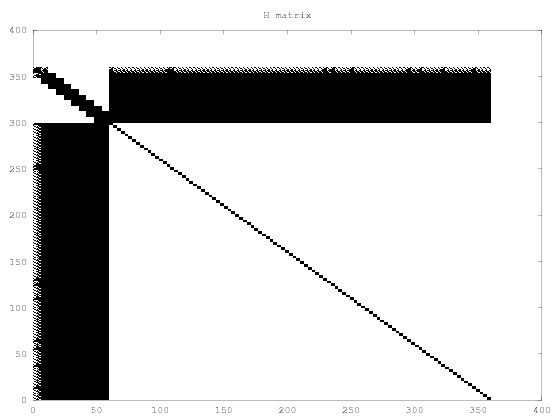

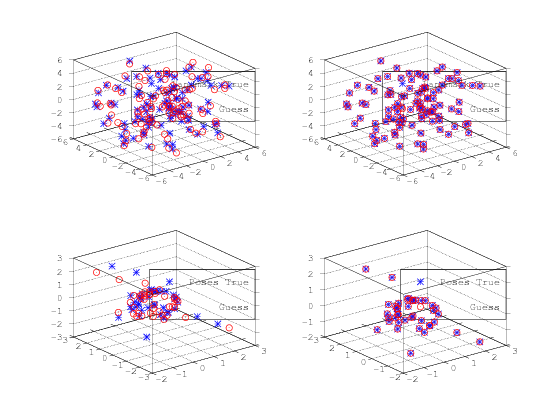

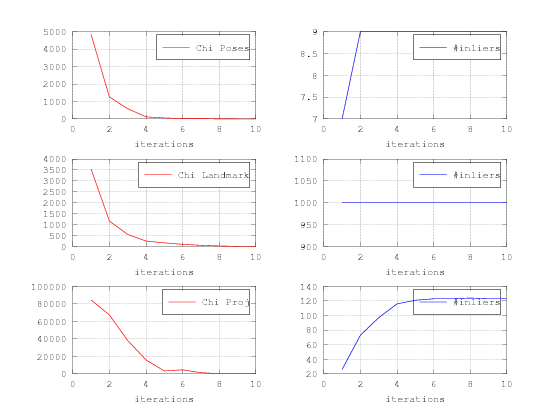

In [18]:
# This is an integrated example that comprises
# 
%source "./total_least_squares.m"

# synthesis of the virtual world
num_landmarks=100;
num_poses=10;
world_size=10;

# landmarks in a matrix, one per column
P_world=(rand(landmark_dim, num_landmarks)-0.5)*world_size;

global K; % camera matrix
global image_rows;
global image_cols;


# poses in an array of 4x4 homogeneous transform matrices
XR_true=zeros(4,4,num_poses);
XL_true=P_world;

# initialize 1st pose
XR_true(:,:,1)=eye(4);

# scaling coefficient for uniform random pose generation
# adjusts the translation to cover world_size
# adjusts the rotation to span the three angles;
rand_scale=eye(6);
rand_scale(1:3,1:3)*=(0.5*world_size);
rand_scale(4:6,4:6)*=pi;

for (pose_num=2:num_poses)
    xr=rand(6,1)-0.5;
    Xr=v2t(rand_scale*xr);
    XR_true(:,:,pose_num)=Xr;
endfor;


######################################## LANDMARK MEASUREMENTS ######################################## 
# generate an ideal number of landmark measurements
# each pose observes each landmark
num_landmark_measurements=num_poses*num_landmarks;
Zl=zeros(landmark_dim,num_landmark_measurements);
landmark_associations=zeros(2,num_landmark_measurements);

measurement_num=1;
for (pose_num=1:num_poses)
    Xr=inv(XR_true(:,:,pose_num));
    for (landmark_num=1:num_landmarks)
    Xl=XL_true(:,landmark_num);
    landmark_associations(:,measurement_num)=[pose_num,landmark_num]';
    Zl(:,measurement_num)=Xr(1:3,1:3)*Xl+Xr(1:3,4);
    measurement_num++;
    endfor;
endfor

######################################## PROJECTION MEASUREMENTS ######################################## 
# generate an ideal number of projection measurements
# each pose observes each landmark
num_projection_measurements=num_poses*num_landmarks;
Zp=zeros(projection_dim,num_projection_measurements);
projection_associations=zeros(2,num_projection_measurements);

measurement_num=1;
for (pose_num=1:num_poses)
    Xr=XR_true(:,:,pose_num);
    for (landmark_num=1:num_landmarks)
    Xl=XL_true(:,landmark_num);
    z_img=projectPoint(Xr,Xl);
    if (z_img(1)>0)
      projection_associations(:,measurement_num)=[pose_num, landmark_num]';
      Zp(:,measurement_num)=z_img;
      measurement_num++;
    endif;
    endfor;
endfor
# crop the projection associations to something meaningful
num_projection_measurements=measurement_num-1;
projection_associations=projection_associations(:,1:num_projection_measurements);
Zp=Zp(:,1:num_projection_measurements);


######################################## POSE MEASUREMENTS ######################################## 

# generate an odometry trajectory for the robot
num_pose_measurements=num_poses-1;
Zr=zeros(4,4,num_pose_measurements);
pose_associations=zeros(2,num_pose_measurements);

measurement_num=1;
for (pose_num=1:num_poses-1)

    Xi=XR_true(:,:,pose_num);
    Xj=XR_true(:,:,pose_num+1);
    pose_associations(:,measurement_num)=[pose_num, pose_num+1]';
    Zr(:,:,measurement_num)=inv(Xi)*Xj;

    measurement_num++;
endfor

############################## GENERATION OF (WRONG) INITIAL GUESS ################################## 

# apply a perturbation to each ideal pose (construct the estimation problem)
pert_deviation=1;
pert_scale=eye(6)*pert_deviation;
XR_guess=XR_true;
XL_guess=XL_true;

for (pose_num=2:num_poses)
    xr=rand(6,1)-0.5;
    dXr=v2t(pert_scale*xr);
    XR_guess(:,:,pose_num)=dXr*XR_guess(:,:,pose_num);
endfor;

#apply a perturbation to each landmark
dXl=(rand(landmark_dim, num_landmarks)-0.5)*pert_deviation;
XL_guess+=dXl;



############################## CALL SOLVER  ################################## 

# uncomment the following to suppress pose-landmark measurements
#Zl=zeros(3,0);

# uncomment the following to suppress pose-landmark-projection measurements
#num_landmarks=0;
# Zp=zeros(3,0);

# uncomment the following to suppress pose-pose measurements
# Zr=zeros(4,4,0);

damping=0;
kernel_threshold=1e3;
num_iterations=10;
[XR, XL,chi_stats_l, num_inliers_l, chi_stats_p, num_inliers_p, chi_stats_r, num_inliers_r, H, b]=doTotalLS(XR_guess, XL_guess, 
    Zl, landmark_associations, 
    Zp, projection_associations, 
    Zr, pose_associations, 
    num_poses, 
    num_landmarks, 
    num_iterations, 
    damping, 
    kernel_threshold);

# Plot State
figure(1);
hold on;
grid;

subplot(2,2,1);
title("Landmark Initial Guess");
plot3(XL_true(1,:),XL_true(2,:),XL_true(3,:),'b*',"linewidth",2);
hold on;
plot3(XL_guess(1,:),XL_guess(2,:),XL_guess(3,:),'ro',"linewidth",2);
legend("Landmark True", "Guess");grid;


subplot(2,2,2);
title("Landmark After Optimization");
plot3(XL_true(1,:),XL_true(2,:),XL_true(3,:),'b*',"linewidth",2);
hold on;
plot3(XL(1,:),XL(2,:),XL(3,:),'ro',"linewidth",2);
legend("Landmark True", "Guess");grid;


subplot(2,2,3);
title("Poses Initial Guess");
plot3(XR_true(1,:),XR_true(2,:),XR_true(3,:),'b*',"linewidth",2);
hold on;
plot3(XR_guess(1,:),XR_guess(2,:),XR_guess(3,:),'ro',"linewidth",2);
legend("Poses True", "Guess");grid;


subplot(2,2,4);
title("Poses After Optimization");
plot3(XR_true(1,:),XR_true(2,:),XR_true(3,:),'b*',"linewidth",2);
hold on;
plot3(XR(1,:),XR(2,:),XR(3,:),'ro',"linewidth",2);
legend("Poses True", "Guess"); grid;


figure(2);
hold on;
grid;
title("chi evolution");

subplot(3,2,1);
plot(chi_stats_r, 'r-', "linewidth", 2);
legend("Chi Poses"); grid; xlabel("iterations");
subplot(3,2,2);
plot(num_inliers_r, 'b-', "linewidth", 2);
legend("#inliers"); grid; xlabel("iterations");

subplot(3,2,3);
plot(chi_stats_l, 'r-', "linewidth", 2);
legend("Chi Landmark"); grid; xlabel("iterations");
subplot(3,2,4);
plot(num_inliers_l, 'b-', "linewidth", 2);
legend("#inliers"); grid; xlabel("iterations");

subplot(3,2,5);
plot(chi_stats_p, 'r-', "linewidth", 2);
legend("Chi Proj"); grid; xlabel("iterations");
subplot(3,2,6);
plot(num_inliers_p, 'b-', "linewidth", 2);
legend("#inliers");grid; xlabel("iterations");

figure(3);
title("H matrix");
H_ =  H./H;                      # NaN and 1 element
H_(isnan(H_))=0;                 # Nan to Zero
H_ = abs(ones(size(H_)) - H_);   # switch zero and one
H_ = flipud(H_);                 # switch rows
colormap(gray(64));
hold on;
image([0.5, size(H_,2)-0.5], [0.5, size(H_,1)-0.5], H_*64);
hold off;
